Land cover classification is a crucial task for monitoring and managing land resources, especially for agricultural purposes. One of the most challenging but significant classifications is cropland identification, which can be vital for monitoring agricultural activities, food security, and land-use changes. The goal of this project is to develop a machine learning algorithm to classify and identify croplands using Sentinel satellite imagery.

entinel satellites, specifically those from the Sentinel-1 and Sentinel-2 missions, provide a wealth of high-resolution data that is invaluable for land cover classification. Sentinel-2's multispectral imagery offers frequent revisit times and high spatial resolution, which makes it ideal for monitoring agricultural landscapes and detecting seasonal changes in croplands. This dataset includes information across multiple bands, such as the Red, Green, Blue, Near-Infrared, and Shortwave Infrared bands, which are particularly useful for distinguishing croplands from other land cover types.

In [1]:
# Loading libraries, the set I alway use...


# File handling and directory operations
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline


In [2]:
print(torch.__version__)


2.3.1+cu121


# Satellite Image Classification Project

This project aims to build familiarity with satellite image classification, using the RGB subset of the EuroSAT dataset for exploratory analysis. The EuroSAT dataset is a benchmark for classifying land use and land cover in Europe, and its RGB subset provides a simplified entry point by focusing on red, green, and blue channels. This initial exploration will help understand the data and its structure before moving to more complex tasks.

In PyTorch, an excellent choice for working with semi-structured image datasets is the `torchvision.datasets.ImageFolder` class. This class is typically used for loading datasets where images are organized into subdirectories corresponding to their class labels. Each subdirectory contains images of a specific class, and `ImageFolder` automatically assigns labels based on folder names.

The first step is to organize the data in the structure required by `ImageFolder`:

i.e root/
    class_1/
        img001.png
        img002.png
        ...
    class_2/
        img001.png
        img002.png
        ...

        
This folder organization ensures that `ImageFolder` can efficiently load the dataset and assign the appropriate labels for each image. The RGB EuroSAT dataset can be arranged in this format for seamless integration into PyTorch workflows.


In [ ]:


# Load the data as a  main path
main_path = '/home/hernan/MLmodels/EuroSat/2750'

# Get the list of folders (directories) in the specified path
folder_names = [folder for folder in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, folder))]

# Print the folder names
for folder in folder_names:
    print(folder)


River
Forest
AnnualCrop
Pasture
Highway
HerbaceousVegetation
Residential
PermanentCrop
SeaLake
Industrial


In [ ]:
#Split in the data in ['train', 'test', 'val']
 
def split_images(input_folder, output_folder, test_size=0.2, val_size=0.05):
    for phase in ['train', 'test', 'val']:
        os.makedirs(os.path.join(output_folder, phase), exist_ok=True)

    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        train_files, test_val_files = train_test_split(files, test_size=test_size + val_size)
        val_split = val_size / (test_size + val_size)
        val_files, test_files = train_test_split(test_val_files, test_size=1 - val_split)

        for phase, phase_files in zip(['train', 'test', 'val'], [train_files, test_files, val_files]):
            phase_folder = os.path.join(output_folder, phase, folder_name)
            os.makedirs(phase_folder, exist_ok=True)
            for file in phase_files:
                shutil.copy(file, phase_folder)

        print(f"Class '{folder_name}': {len(train_files)} train, {len(test_files)} test, {len(val_files)} val images.")

# Paths for the dataset and output folder
main_path = '/home/hernan/MLmodels/EuroSat/2750'
output_path = '/home/hernan/MLmodels/EuroSat/split_data'

# Split data into train, test, and validation sets
split_images(main_path, output_path)


Class 'River': 1875 train, 500 test, 125 val images.
Class 'Forest': 2250 train, 600 test, 150 val images.
Class 'AnnualCrop': 2250 train, 600 test, 150 val images.
Class 'Pasture': 1500 train, 400 test, 100 val images.
Class 'Highway': 1875 train, 500 test, 125 val images.
Class 'HerbaceousVegetation': 2250 train, 600 test, 150 val images.
Class 'Residential': 2250 train, 600 test, 150 val images.
Class 'PermanentCrop': 1875 train, 500 test, 125 val images.
Class 'SeaLake': 2250 train, 600 test, 150 val images.
Class 'Industrial': 1875 train, 500 test, 125 val images.


In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

# Define the directories for training and testing data
train_dir = output_path + '/train'
test_dir = output_path + '/test'

# Define the transformations with data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize(255),  # Resize the images
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(30),  # Randomly rotate images by up to 30 degrees
    transforms.CenterCrop(224),  # Crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image for ResNet
])

# Define the transformations for the testing set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(255),  # Resize the images
    transforms.CenterCrop(224),  # Crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image for ResNet
])

# Load the training dataset with augmentation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the testing dataset without augmentation
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the number of batches in train_loader and test_loader
print(f'Training batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')


Training batches: 633
Test batches: 169


In [34]:
train_loader.dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
# New way (using weights)
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the last layer to match the number of classes in your dataset
num_classes = len(train_loader.dataset.classes)  # The number of classes based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU (if available)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize metrics lists
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

# Training loop
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Loop through the training data
    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Collect predictions and true labels
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Calculate accuracy for this epoch
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    train_accuracies.append(accuracy)

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1s.append(f1)

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Optionally, you can save the model after training
from datetime import datetime

# Save the model with a unique name based on the current time
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'trained_model_{timestamp}.pth'
torch.save(model.state_dict(), filename)


In [ ]:

# After training, you can plot the metrics if needed
import matplotlib.pyplot as plt


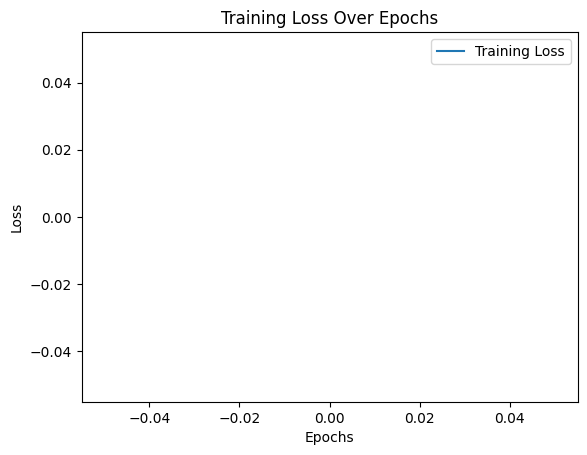

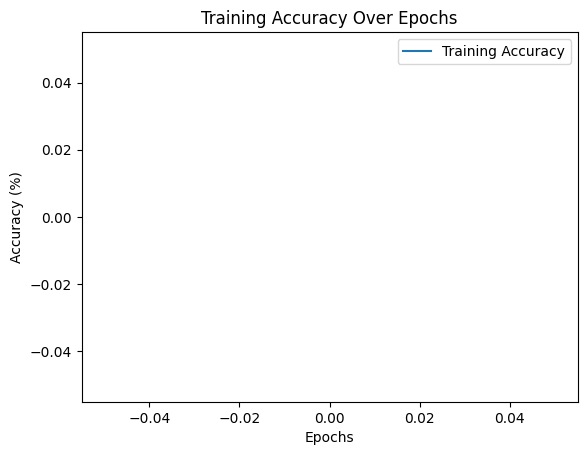

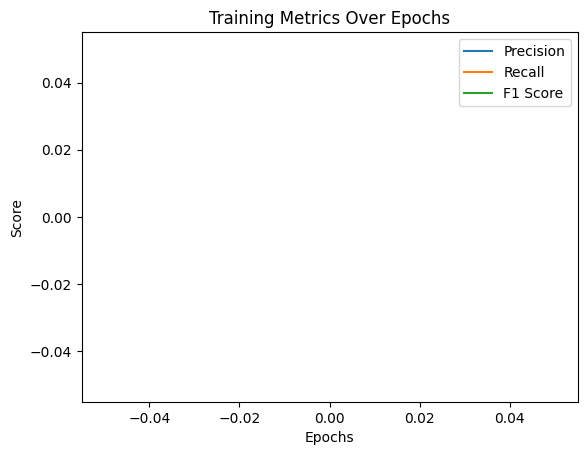

In [29]:

# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Plot precision, recall, F1 score
plt.plot(train_precisions, label='Precision')
plt.plot(train_recalls, label='Recall')
plt.plot(train_f1s, label='F1 Score')
plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()


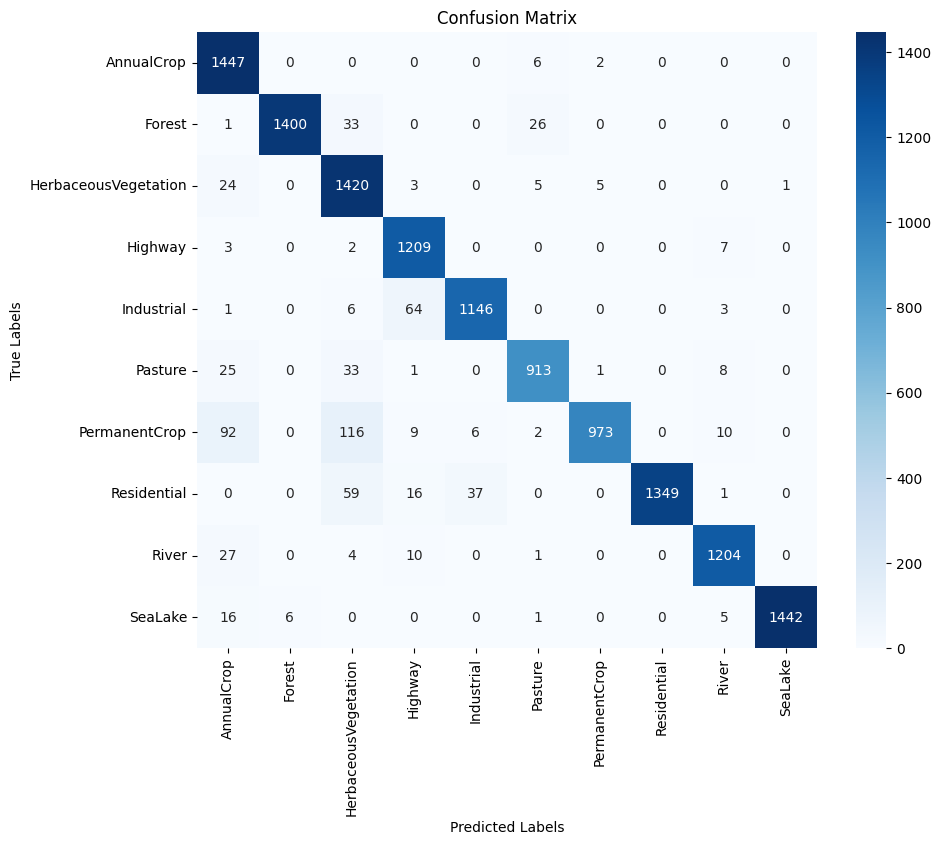

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model and compute the confusion matrix
def evaluate_model(model, data_loader, classes):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(classes)))

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

# Evaluate the model on the test set
classes = train_loader.dataset.classes  # Get the class names from the dataset
confusion_matrix_result = evaluate_model(model, test_loader, classes)


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the image transformation (same as used in training)
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

def predict_image(image_path, model, transform, device, classes):
    """
    Predicts the class of a single image using a trained model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained PyTorch model.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (str): Device to use ('cuda' or 'cpu').
        classes (list): List of class names.

    Returns:
        str: Predicted class label.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    # Map prediction to class name
    predicted_label = classes[predicted_class.item()]
    return predicted_label


# # Example usage
# if __name__ == "__main__":
#     # Path to the image
#     image_path = "/home/hernan/MLmodels/EuroSat/split_data/test/Industrial/Industrial_62.jpg"

#     # List of classes
#     classes = train_loader.dataset.classes  # Automatically extracted from dataset

#     # Predict
#     predicted_label = predict_image(image_path, model, transform, device, classes)
#     print(f"Predicted Label: {predicted_label}")


In [12]:
# Load the pre-trained ResNet model
# New way (using weights)
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# Modify the last layer to match the number of classes in your dataset
num_classes = 10  # The number of classes based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [13]:
model.load_state_dict(torch.load('/home/hernan/MLmodels/EuroSat/trained_model.pth'))
model.eval()  # Ensure the model is in evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == "__main__":
    model.load_state_dict(torch.load('/home/hernan/MLmodels/EuroSat/trained_model.pth'))

    # Path to the image
    image_path = "/home/hernan/MLmodels/EuroSat/split_data/test/Forest/Forest_4.jpg"

    # List of classes
    classes = ['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake'] #  extracted from dataset

    # Predict
    predicted_label = predict_image(image_path, model, transform, device, classes)
    print(f"Predicted Label: {predicted_label}")


Predicted Label: Forest


#### Now it's time to try segmentation, but what is segmentation?, what it is in the context of DeepLearning and for what is usefull?

Here some explanations that can help to understand the task,

### What is Segmentation in the Context of Deep Learning?
Segmentation in the context of deep learning refers to the task of partitioning an image into meaningful regions, where each region corresponds to a specific object or class of interest. Specifically, in semantic segmentation, the goal is to classify each pixel in an image into a predefined category. For example, in satellite imagery, you could classify each pixel as belonging to categories such as forest, lake, urban, or agriculture. Instance segmentation goes a step further by not only classifying pixels but also distinguishing between individual objects of the same class (e.g., multiple cars or trees).

In deep learning, semantic segmentation typically uses convolutional neural networks (CNNs) or advanced models like UNet, DeepLabV3+, and Mask R-CNN to perform pixel-wise classification. These models learn hierarchical representations of the image at various scales, enabling them to understand spatial relationships and complex patterns across an image.

In [1]:
# When come to this kind of task, it's always usefull to train in the GPU. In this oportunity I will be more conservative and
# I will put a limit to the GPU usage, in order to avoid overchargin.

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set GPU memory limits
if device.type == 'cuda':
    torch.cuda.set_per_process_memory_fraction(0.8, 0)  # Limit to 80% GPU memory

NameError: name 'torch' is not defined

### The New Data:
#### About Dataset
Automatic categorization and segmentation of land cover is of great importance for sustainable development, autonomous agriculture, and urban planning. DeepGlobe Land Cover Classification Challenge introduces the challenge of automatic classification of land cover types. This problem is defined as a multi-class segmentation task to detect areas of urban, agriculture, rangeland, forest, water, barren, and unknown.

#### Acknowledgements
This dataset was obtained from Land Cover Classification Track in DeepGlobe Challenge . For more details on the dataset refer the related publication - DeepGlobe 2018: A Challenge to Parse the Earth through Satellite Images

In [86]:
#Connected by the kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/deepglobe-land-cover-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.74G/2.74G [02:07<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /home/hernan/.cache/kagglehub/datasets/balraj98/deepglobe-land-cover-classification-dataset/versions/2


In [ ]:
#new_path ="/home/hernan/MLmodels/EuroSat"
#!mv /home/hernan/.cache/kagglehub/datasets/balraj98/deepglobe-land-cover-classification-dataset/versions/2 /home/hernan/MLmodels/EuroSat

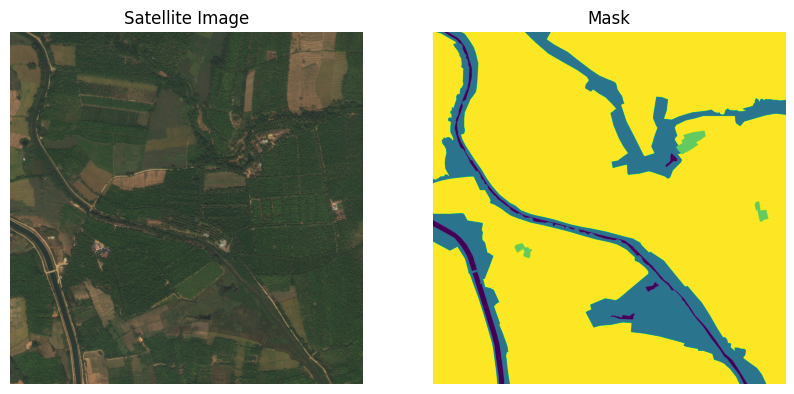

In [ ]:
## see some picture 
from PIL import Image
import matplotlib.pyplot as plt

# Load the satellite image
image = Image.open('/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/119_sat.jpg').convert('RGB')

# Load the mask
mask = Image.open('/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/119_mask.png').convert('L')

# Display the image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Satellite Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.show()


In [91]:
from sklearn.model_selection import train_test_split
from glob import glob


In [106]:
import os
from glob import glob
# Example usage

# Assuming this is your directory
directory = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/"

# Get all files in the directory
images = os.listdir(directory)
# Remove "_sat" by splitting
images_without_sat = [img.split("_sat")[0] + ".jpg" for img in images if "_sat" in img]
mask_without_mask = [img.split("_mask")[0] + ".png" for img in images if "_mask" in img]

print(mask_without_mask)


['613687.png', '726265.png', '457265.png', '798411.png', '340898.png', '524056.png', '442329.png', '276912.png', '514414.png', '458776.png', '491356.png', '402002.png', '439854.png', '765792.png', '315352.png', '141685.png', '468103.png', '586670.png', '805150.png', '678520.png', '544537.png', '910525.png', '182027.png', '120625.png', '10901.png', '467855.png', '430587.png', '855.png', '347676.png', '880610.png', '192918.png', '893261.png', '772567.png', '210669.png', '340798.png', '651774.png', '511850.png', '323581.png', '904606.png', '994520.png', '682046.png', '563092.png', '226788.png', '605037.png', '499161.png', '942986.png', '530040.png', '159322.png', '655313.png', '753408.png', '600230.png', '570332.png', '834900.png', '927126.png', '312676.png', '845069.png', '588542.png', '604647.png', '269601.png', '28559.png', '839012.png', '100694.png', '774779.png', '329017.png', '21023.png', '96841.png', '33573.png', '81011.png', '296279.png', '337272.png', '698065.png', '95863.png', '

In [107]:
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split

def load_data(
    data_path_image, 
    data_path_mask, 
    split=0.2, 
    base_output_dir="/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data",
    image_ext=".jpg",
    mask_ext=".png"
):
    """
    Splits image and mask data into training and testing datasets and saves them in structured directories.

    Args:
        data_path_image (str): Path to the directory containing image files.
        data_path_mask (str): Path to the directory containing mask files.
        split (float): Proportion of data to use for the test set.
        base_output_dir (str): Base directory to save split data.
        image_ext (str): File extension for image files (default is '.jpg').
        mask_ext (str): File extension for mask files (default is '.png').

    Returns:
        tuple: Training and testing data pairs as ((train_images, train_masks), (test_images, test_masks)).
    """
    # Validate input directories
    if not os.path.exists(data_path_image) or not os.path.exists(data_path_mask):
        raise ValueError("Image or mask directory does not exist.")

    # Create output directories
    dirs = ['train', 'test']
    subdirs = ['images', 'masks']
    for dir in dirs:
        for subdir in subdirs:
            os.makedirs(os.path.join(base_output_dir, dir, subdir), exist_ok=True)

    # Load and pair images with masks
    images = sorted(glob(os.path.join(data_path_image, f"*{image_ext}")))
    masks = sorted(glob(os.path.join(data_path_mask, f"*{mask_ext}")))

    if len(images) != len(masks):
        raise ValueError("Number of images and masks do not match. Ensure they are correctly paired.")

    # Pair images and masks by filename
    paired_data = [(img, msk) for img, msk in zip(images, masks) if os.path.basename(img).split("_sat")[0] == os.path.basename(msk).split("_mask")[0]]

    if not paired_data:
        raise ValueError("No valid image-mask pairs found. Check file naming convention.")

    images, masks = zip(*paired_data)

    # Split data into training and testing
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=split, random_state=42)

    # Copy files to respective directories
    for dataset, folder in zip([(train_x, train_y), (test_x, test_y)], dirs):
        for files, subdir in zip(dataset, subdirs):
            for file in files:
                shutil.copy2(file, os.path.join(base_output_dir, folder, subdir, os.path.basename(file)))

    print(f"Data split completed.")
    print(f"Training: {len(train_x)} images, {len(train_y)} masks.")
    print(f"Testing: {len(test_x)} images, {len(test_y)} masks.")

    return (train_x, train_y), (test_x, test_y)

# Example usage
data_path_image = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/"
data_path_mask = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/"
load_data(data_path_image, data_path_mask, split=0.2)


Data split completed.
Training: 642 images, 642 masks.
Testing: 161 images, 161 masks.


((['/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/586222_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/736869_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/599743_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/81039_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/476582_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/830444_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/181447_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/269601_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/499418_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/508571_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/586670_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/570992_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/589940_sat.jpg',
   '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/train/635841_sat.jpg',
   '/ho

In [109]:
import pandas as pd

In [110]:
clasdf = pd.read_csv("/home/hernan/MLmodels/EuroSat/DeepGlobe_set/class_dict.csv")
metadata = pd.read_csv("/home/hernan/MLmodels/EuroSat/DeepGlobe_set/metadata.csv")

#Note there is no not mask in the test data
np.unique(metadata["split"].values)
test_metadata = metadata[metadata["split"]=="test"]
test_metadata["mask_path"].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=object)

### In this part I will implement a NN for segmentation based on:

https://doi.org/10.48550/arXiv.1505.04597

A diagram of the model is also provided

![U-Net Architecture](./U_net_arch.png)


As illustrated in the U-Net architecture diagram, the structure is easier to understand when broken down step-by-step. By analyzing the diagram and counting the components, we observe the following:

Contracting Path (Left Side):

The contracting path follows a standard convolutional network design. Each step includes:
Two 3×3 Convolutions: These reduce the field of view, preserve spatial resolution, and double the number of feature channels.
ReLU Activation: Non-linear transformation is applied after each convolution.
2×2 Max Pooling: Spatial dimensions are halved with each pooling operation, facilitating hierarchical feature extraction.

Bottleneck: At the bottom of the U-shape, the feature map has the smallest spatial dimensions but the largest depth (number of channels). This stage captures the most abstract features.

Expansive Path (Right Side):

Each step mirrors the contracting path and includes:
Upsampling (2×2 Up-Convolution): Spatial dimensions are doubled, and feature channels are halved.
Skip Connections: Features from the corresponding layer in the contracting path are concatenated with the upsampled features to retain high-resolution details.
Two 3×3 Convolutions with ReLU: These refine the combined feature maps.
Output Layer:

A 1×1 Convolution is applied to map the 64-channel feature vector to the desired number of output classes.
By following the diagram, it's evident how the spatial dimensions and feature channels evolve:

Spatial Dimensions: Halve during the contracting path $H \times W \to \frac{H}{2^{n}} \times \frac{W}{2^{n}}$ and double during the expansive path $\frac{H}{2^{n}} \times \frac{W}{2^{n}} \to  H \times W $

Feature Channels: Double during the contracting path and halve during the expansive path.


###

In [2]:
## The Network can be implemented as:

import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF

##Firts the implementation of a new class for the double convolutional layers, note that the ouput of the firts ones is
##the imput of the second one, in the original paper there is note a batch normalization. Here I want to say something about
##

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            ) ##Here es wete we are adding the skip connetion
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse the skip connections for upsampling
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Transposed convolution
            skip_connection = skip_connections[idx // 2]

            # Resize skip connection if necessary
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)  # DoubleConv

        return self.final_conv(x)


In [137]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, g):
        # x: skip connection from encoder (N, C, H, W)
        # g: gating signal from decoder (N, C, H, W)
        
        query = self.query_conv(x)  # (N, C//8, H, W)
        key = self.key_conv(x)  # (N, C//8, H, W)
        value = self.value_conv(x)  # (N, C, H, W)
        
        # Compute attention map
        energy = torch.matmul(query.view(query.size(0), query.size(1), -1).permute(0, 2, 1),
                              key.view(key.size(0), key.size(1), -1))
        attention = torch.softmax(energy, dim=-1)
        out = torch.matmul(attention, value.view(value.size(0), value.size(1), -1))
        
        out = out.view(value.size(0), value.size(1), value.size(2), value.size(3))  # Reshape back to (N, C, H, W)
        out = self.gamma * out + x  # Apply the attention-weighted output
        
        return out

class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetWithAttention, self).__init__()
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path with Attention Block
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            ) 
            self.ups.append(DoubleConv(feature * 2, feature))
            self.ups.append(AttentionBlock(feature))  # Add Attention Block after each upsample step

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse the skip connections for upsampling
        skip_connections = skip_connections[::-1]

        # Upsampling with Attention Block
        for idx in range(0, len(self.ups), 3):  # Adjusted for 3 components (ConvTranspose, DoubleConv, Attention)
            x = self.ups[idx](x)  # Transposed convolution (upsampling)
            skip_connection = skip_connections[idx // 3]

            # Resize skip connection if necessary
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Attention mechanism
            x = self.ups[idx + 2](x, skip_connection)  # Apply Attention Block

            # Concatenate skip connection and the output from attention block
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)  # DoubleConv after concatenation

        return self.final_conv(x)


In [ ]:


# Test Function
def test():
    x = torch.randn((3, 3, 161, 161))  # Batch size = 3, 1 channel, 161x161 image
    model = UNet(in_channels=3, out_channels=7)
    pred = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {pred.shape}")
    #assert pred.shape == x.shape  # Ensure output shape matches input shape


if __name__ =="__main__":
    test()

Input shape: torch.Size([3, 3, 161, 161])
Output shape: torch.Size([3, 7, 161, 161])


In [ ]:
import os

# Path to the folder
folder_path = '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/train/masks'

# List all files in the directory
files = os.listdir(folder_path)

# Iterate through the files and rename them
for filename in files:
    if os.path.isfile(os.path.join(folder_path, filename)):
        # Split the filename and extension
        name, ext = os.path.splitext(filename)
        
        # Remove the suffix (for example, "_v1", "_v2")
        new_name = name.rsplit('_', 1)[0]  # Remove the last underscore and everything after it
        
        # Add the extension back
        new_name = new_name + ext

        # Full paths to the old and new files
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)

        print(f"Renamed: {filename} -> {new_name}")



Class mask:
3


tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

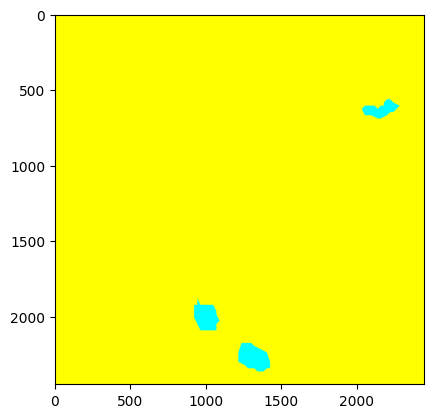

In [40]:
# Define the color map
COLOR_MAP = {
    (0, 255, 255): 0,  # Urban land
    (255, 255, 0): 1,  # Agriculture land
    (255, 0, 255): 2,  # Rangeland
    (0, 255, 0): 3,    # Forest land
    (0, 0, 255): 4,    # Water
    (255, 255, 255): 5, # Barren land
    (0, 0, 0): 6       # Unknown
}

# Example RGB mask as a NumPy array (replace with your actual mask)
example_rgb_mask = Image.open("/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/train/masks/266.png")  # Convert to grayscale (binary mask)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the model's input size (e.g., 224x224 for ResNet)
    transforms.ToTensor(),          # Convert to a PyTorch tensor (scales values to [0, 1])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


# Convert RGB mask to class indices
tensor_image = transform(example_rgb_mask)

print("Class mask:")
plt.imshow(example_rgb_mask)
print(len(tensor_image))
tensor_image[0]
#

In [43]:
mask_array = np.array(example_rgb_mask)
len(mask_array)

2448

In [8]:
import numpy as np

COLOR_MAP = {
    "Urban land": {"RGB": (0, 255, 255), "Class Index": 0},
    "Agriculture land": {"RGB": (255, 255, 0), "Class Index": 1},
    "Rangeland": {"RGB": (255, 0, 255), "Class Index": 2},
    "Forest land": {"RGB": (0, 255, 0), "Class Index": 3},
    "Water": {"RGB": (0, 0, 255), "Class Index": 4},
    "Barren land": {"RGB": (255, 255, 255), "Class Index": 5},
    "Unknown": {"RGB": (0, 0, 0), "Class Index": 6}
}

def rgb_to_class_index(mask, color_map):
    # Create an empty mask to store class indices
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    
    # Iterate through the dictionary and compare each RGB value
    for class_name, class_info in color_map.items():
        rgb_value = class_info["RGB"]
        class_index = class_info["Class Index"]
        
        # Compare the mask RGB values with the current class RGB value
        # Using np.all() to check if the RGB value of each pixel matches the class RGB value
        class_mask[np.all(mask == np.array(rgb_value), axis=-1)] = class_index
    
    return class_mask


class_mask_rgb = Image.open("/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/train/masks/119.png")# Random RGB mask
class_mask_array = np.array(class_mask_rgb)

class_mask = rgb_to_class_index(class_mask_array, COLOR_MAP)

print(class_mask)


[[2 2 2 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [4]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DeepGlobeDataSet(Dataset):
    def __init__(self, ima_dir, mask_dir, transform=None, color_map=None):
        self.ima_dir = ima_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.color_map = color_map  # Save the color map
        
        # List all image files
        self.images = os.listdir(ima_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # Get image and mask paths
        ima_path = os.path.join(self.ima_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))  # Assuming the mask file name pattern

        # Open image and mask
        image = Image.open(ima_path).convert('RGB')  # Convert to RGB
        mask = Image.open(mask_path).convert('RGB')  # Convert to RGB
        
        # Convert images to numpy arrays for albumentations
        image = np.array(image)
        mask = np.array(mask)
        #image = image/255.0
        # Convert the mask from RGB to class indices
        mask = self.rgb_to_class_index(mask)

        # Apply augmentations (if any)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask
    
    def rgb_to_class_index(self, mask):
        """
        Convert an RGB mask to class indices based on the color_map.
        """
        # Create an empty mask to store class indices
        class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        
        # Iterate through the dictionary and map RGB values to class indices
        for class_name, class_info in self.color_map.items():
            rgb_value = class_info["RGB"]
            class_index = class_info["Class Index"]
            
            # Compare the mask RGB values with the current class RGB value
            class_mask[np.all(mask == np.array(rgb_value), axis=-1)] = class_index
        
        return class_mask



In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2# Define augmentations

transform = A.Compose([
    A.Resize(255, 255),  # Resize to 128x128 (adjust to your needs)
    A.Rotate(limit=40, p=0.5),  # Random rotation up to 40 degrees
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),  # Random vertical flip
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),  # Normalize with ImageNet stats
    ToTensorV2(),  # Convert to Tensor
])



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
ima_dir = '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/train/images'
mask_dir = '/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/train/masks'
train_dataset = DeepGlobeDataSet(ima_dir, mask_dir, transform=transform,color_map=COLOR_MAP)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8,num_workers=8,pin_memory=True, shuffle=True)

test_ima_dir = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/test/images"
test_mask_dir = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/test/masks"
test_data_set = DeepGlobeDataSet(test_ima_dir, test_mask_dir, transform=transform,color_map=COLOR_MAP)
test_loader = torch.utils.data.DataLoader(test_data_set, batch_size=8,num_workers=8,pin_memory=True, shuffle=True)



In [ ]:
# Iterate through the dataset
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    
    # Manually select the first two images
    two_images = images[:2]  # First two images in the batch
    two_masks = masks[:2]  # First two masks in the batch
    
    # Print their shapes
    print(f"Two Images Shape: {two_images.shape}")  # Should print torch.Size([2, 3, 128, 128])
    print(f"Two Masks Shape: {two_masks.shape}, Mask type: {two_masks.dtype}")  # Should print torch.Size([2, 128, 128])
    
    # Inspect the actual tensor values
    print(f"First Image Tensor: {two_images[0].cpu().numpy()}")
    print(f"First Mask Tensor: {two_masks[0].cpu().numpy()}")
    
    break  # Just to test two images from the batch



In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")


Using cuda


In [12]:
from tqdm.notebook import tqdm  
import torch
import torch.nn as nn
from torch.optim import Adam
import time

# Define Model, Loss, Optimizer
model = UNet(in_channels=3, out_channels=7)
criterion = nn.CrossEntropyLoss()  # For multiclass segmentation
optimizer = Adam(model.parameters(), lr=1e-4)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

# Metric function to compute IoU
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = torch.argmax(preds, dim=1)
    preds = preds.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union > 0:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.mean(ious)

# Training Loop
num_epochs = 20
num_classes = 7
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    epoch_loss = 0.0
    epoch_iou = 0.0
    start_time = time.time()

    for index, (images, masks) in enumerate(loop):
        images = images.to(device)  # Move images to the GPU
        masks = masks.to(device).long()  # Move masks to the GPU and ensure they are in long format for CrossEntropyLoss
        
        # Forward pass
        with torch.cuda.amp.autocast():  # Mixed precision training
            preds = model(images)  # Model outputs raw logits (shape: [batch_size, num_classes, height, width])
            loss = criterion(preds, masks)  # Compute the loss

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        
        # Compute IoU for the batch
        batch_iou = compute_iou(preds, masks, num_classes)
        epoch_iou += batch_iou

        # Update tqdm progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), batch_iou=batch_iou)

    # Print epoch results
    avg_loss = epoch_loss / len(train_loader)
    avg_iou = epoch_iou / len(train_loader)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Time: {elapsed_time:.2f}s")
    
    # Save the model after each epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")  # Save model state dictionary after each epoch

# Save the final model after training
torch.save(model.state_dict(), "unet_final.pth")  # Save the final model at the end of training


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.3869, IoU: 0.1979, Time: 141.75s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2/20, Loss: 1.2005, IoU: 0.2407, Time: 125.03s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3/20, Loss: 1.1130, IoU: 0.2581, Time: 129.14s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 4/20, Loss: 1.0250, IoU: 0.2814, Time: 122.75s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 5/20, Loss: 0.9975, IoU: 0.2785, Time: 123.65s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 6/20, Loss: 0.9332, IoU: 0.3068, Time: 126.79s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 7/20, Loss: 0.8999, IoU: 0.3146, Time: 126.38s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 8/20, Loss: 0.8911, IoU: 0.3276, Time: 128.52s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 9/20, Loss: 0.8959, IoU: 0.3107, Time: 126.19s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 10/20, Loss: 0.8446, IoU: 0.3212, Time: 126.39s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 11/20, Loss: 0.7801, IoU: 0.3533, Time: 128.26s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 12/20, Loss: 0.7985, IoU: 0.3462, Time: 126.75s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 13/20, Loss: 0.7646, IoU: 0.3567, Time: 127.92s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 14/20, Loss: 0.7802, IoU: 0.3459, Time: 125.36s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 15/20, Loss: 0.7545, IoU: 0.3578, Time: 125.04s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 16/20, Loss: 0.7521, IoU: 0.3584, Time: 125.89s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 17/20, Loss: 0.7502, IoU: 0.3566, Time: 127.92s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 18/20, Loss: 0.7476, IoU: 0.3592, Time: 124.99s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 19/20, Loss: 0.7430, IoU: 0.3575, Time: 127.59s


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 20/20, Loss: 0.7478, IoU: 0.3509, Time: 126.72s


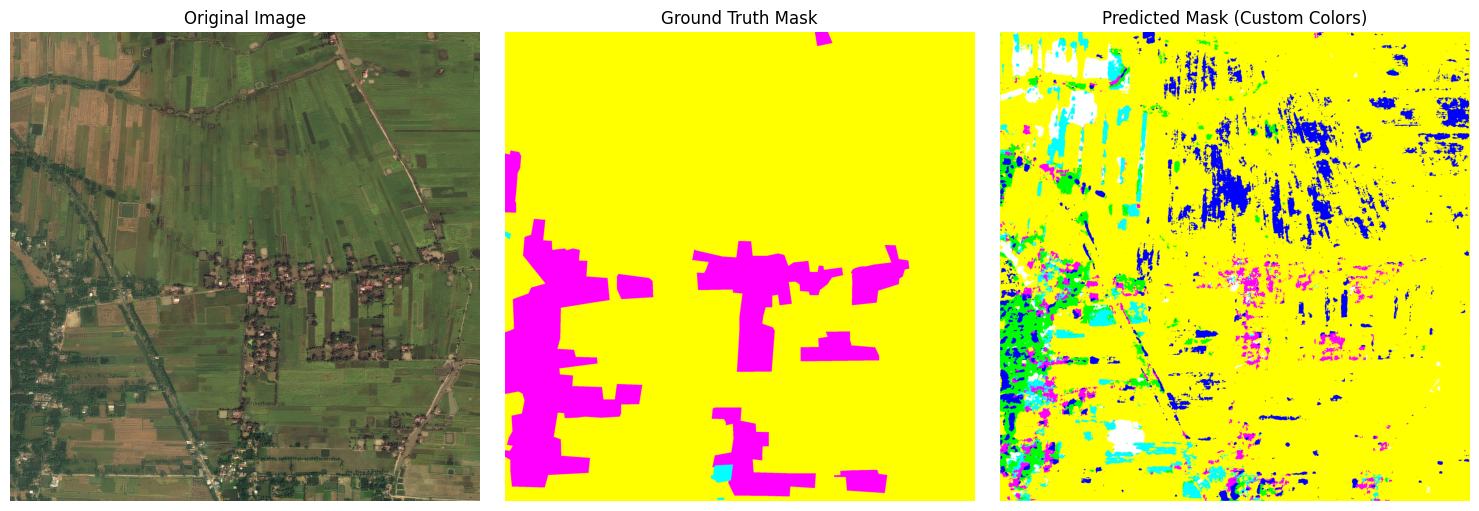

In [16]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the COLOR_MAP as used during training
COLOR_MAP = {
    "Urban land": {"RGB": (0, 255, 255), "Class Index": 0},
    "Agriculture land": {"RGB": (255, 255, 0), "Class Index": 1},
    "Rangeland": {"RGB": (255, 0, 255), "Class Index": 2},
    "Forest land": {"RGB": (0, 255, 0), "Class Index": 3},
    "Water": {"RGB": (0, 0, 255), "Class Index": 4},
    "Barren land": {"RGB": (255, 255, 255), "Class Index": 5},
    "Unknown": {"RGB": (0, 0, 0), "Class Index": 6}
}

# Load the saved model
model = UNet(in_channels=3, out_channels=7)  # Adjust the number of output classes if necessary
model.load_state_dict(torch.load("unet_final.pth"))
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((1920, 1920)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load and preprocess the image
image_path = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/test/images/204562.jpg"
image = Image.open(image_path).convert("RGB")  # Load your satellite image
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Load the corresponding mask image
mask_path = "/home/hernan/MLmodels/EuroSat/DeepGlobe_set/split_data/test/masks/204562.png"
image_mask = Image.open(mask_path).convert("RGB")  # Load the ground truth mask

# Make prediction
with torch.no_grad():  # No need for gradients in inference
    preds = model(image_tensor)
    preds = torch.argmax(preds, dim=1)  # For multi-class segmentation, choose the class with the highest probability

# Convert the predictions to a format that can be visualized
preds = preds.squeeze().cpu().numpy()  # Remove batch and channel dimension, convert to numpy array

# Create an empty image for the colored prediction mask
pred_colored = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

# Map each class index to the corresponding RGB value from COLOR_MAP
for class_name, class_info in COLOR_MAP.items():
    # Get the class index and RGB color
    class_index = class_info["Class Index"]
    rgb_color = class_info["RGB"]
    
    # Assign the RGB color to all pixels corresponding to this class
    pred_colored[preds == class_index] = rgb_color

# Convert the original image to numpy for visualization
image_np = transforms.ToTensor()(image).permute(1, 2, 0).numpy()

# Plot the original image, ground truth mask, and predicted mask with custom colors
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax[0].imshow(image_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground truth mask
ax[1].imshow(image_mask)
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

# Predicted mask with custom colors applied
ax[2].imshow(pred_colored)
ax[2].set_title('Predicted Mask (Custom Colors)')
ax[2].axis('off')

plt.tight_layout()
plt.show()



## Implementing Semantic Segmentation Models (UNet and DeepLabV3+) with Bayesian Search
Below, I describe a practical approach to implementing segmentation models with PyTorch, optimizing hyperparameters using Bayesian Search, and efficiently using my GPU resources. 

In [ ]:
#As it was done before the Pytorch library already include a pretained model of DeepLabV3+, I will use it

import torch
from torchvision import models
from torch import nn

# Load a pretrained DeepLabV3+ model
model = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the classifier for custom classes (e.g., 3 classes: forest, lake, urban)
num_classes = 3  # For example: forest, lake, urban
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


'/home/hernan/.cache/kagglehub/datasets/balraj98/deepglobe-land-cover-classification-dataset/versions/2'

In [ ]:
## Unet from scratch

